# Implementing K Means clustering for the antobody mean escape over time.

Import Python modules

In [13]:
import os
import glob
from collections import defaultdict
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.colors as colors

Read in data that predicts how much each virus has escaped each antibody

In [2]:
f = '/fh/fast/matsen_e/shared/dmsa-pred/ncov-dmsa/results/cao_predictions/imprinted_2022_abs/all_predictions.csv'
escape_df = pd.read_csv(f)
escape_df.rename(columns={'group':'ab_group'}, inplace=True)
escape_df['escape_score'].clip(upper=1.0, inplace=True)
escape_df.head()

strain aa_substitutions  escape_score   antibody ab_group        date  \
0  ON641975.1              NaN      0.000000  BD55-6049       E3  2022-01-08   
1  ON641975.1      G446S N501Y      0.020197   BD56-965        B  2022-01-08   
2  ON641975.1              NaN      0.000000    XGv-318       F1  2022-01-08   
3  ON641975.1              NaN      0.000000  BD55-5687       E3  2022-01-08   
4  ON641975.1            E484A      0.005702    XGv-214     E2.1  2022-01-08   

  Nextstrain_clade      time  
0                ?  2.038356  
1                ?  2.038356  
2                ?  2.038356  
3                ?  2.038356  
4                ?  2.038356

Next, for each antibody group, we'll plot escape over time. To do this, we'll need to implement our sliding-window approach from before. First, we will define where our windows are.

In [3]:
# Define parameters for windows
start_time = 0
end_time = 3.3
window_width = 0.2
window_step_size = 0.1

# To start, we set the left side of our window at a value
# of zero
left_side_of_window = 0

# We're going to define all windows one at a time
# based on the step size and width
list_of_left_sides_of_windows = []
while left_side_of_window <= end_time:
    
    # Append the window value to the list
    list_of_left_sides_of_windows.append(left_side_of_window)
    #print(left_side_of_window, left_side_of_window+window_width)

    # Slide the window to the right by one step
    left_side_of_window = left_side_of_window + window_step_size
escape_df.head()

strain aa_substitutions  escape_score   antibody ab_group        date  \
0  ON641975.1              NaN      0.000000  BD55-6049       E3  2022-01-08   
1  ON641975.1      G446S N501Y      0.020197   BD56-965        B  2022-01-08   
2  ON641975.1              NaN      0.000000    XGv-318       F1  2022-01-08   
3  ON641975.1              NaN      0.000000  BD55-5687       E3  2022-01-08   
4  ON641975.1            E484A      0.005702    XGv-214     E2.1  2022-01-08   

  Nextstrain_clade      time  
0                ?  2.038356  
1                ?  2.038356  
2                ?  2.038356  
3                ?  2.038356  
4                ?  2.038356

Next, for each window, we will record data in that window.

In [4]:
# Make a dictionary for keeping track of averages in each window
window_data = defaultdict(list)

ab_groups = sorted(escape_df['ab_group'].unique())

# Iterate over each window and record data
dfs = []
for left_side_of_window in list_of_left_sides_of_windows:

    # Get the right side of the window
    right_side_of_window = left_side_of_window + window_width
   
    # Record data for specific antibody group
    for ab_group in ab_groups:
       
        # Get data for all rows in a given time window
        data = escape_df[
            (escape_df['time'].between(left_side_of_window, right_side_of_window)) &
            (escape_df['ab_group'] == ab_group)
        ].copy()

        # Compute the mean escape across all viruses for a given antibody
        data = data.groupby('antibody').mean(numeric_only=True)
        data['time'] = left_side_of_window
        data['ab_group'] = ab_group
        dfs.append(data)
           
ab_window_data = pd.concat(dfs)
ab_window_data.rename(columns={'escape_score' : 'mean_escape'}, inplace=True)
ab_window_data.reset_index(inplace=True)
print(ab_window_data.info())
ab_window_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91674 entries, 0 to 91673
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   antibody     91674 non-null  object 
 1   mean_escape  91674 non-null  float64
 2   time         91674 non-null  float64
 3   ab_group     91674 non-null  object 
dtypes: float64(2), object(2)
memory usage: 2.8+ MB
None


antibody  mean_escape  time ab_group
0      B38          0.0   0.0        A
1   BD-218          0.0   0.0        A
2   BD-236          0.0   0.0        A
3   BD-369          0.0   0.0        A
4   BD-395          0.0   0.0        A

Now, let's plot ALL of the data together and see our mean antibody escape over time for all ~3000 antibodies

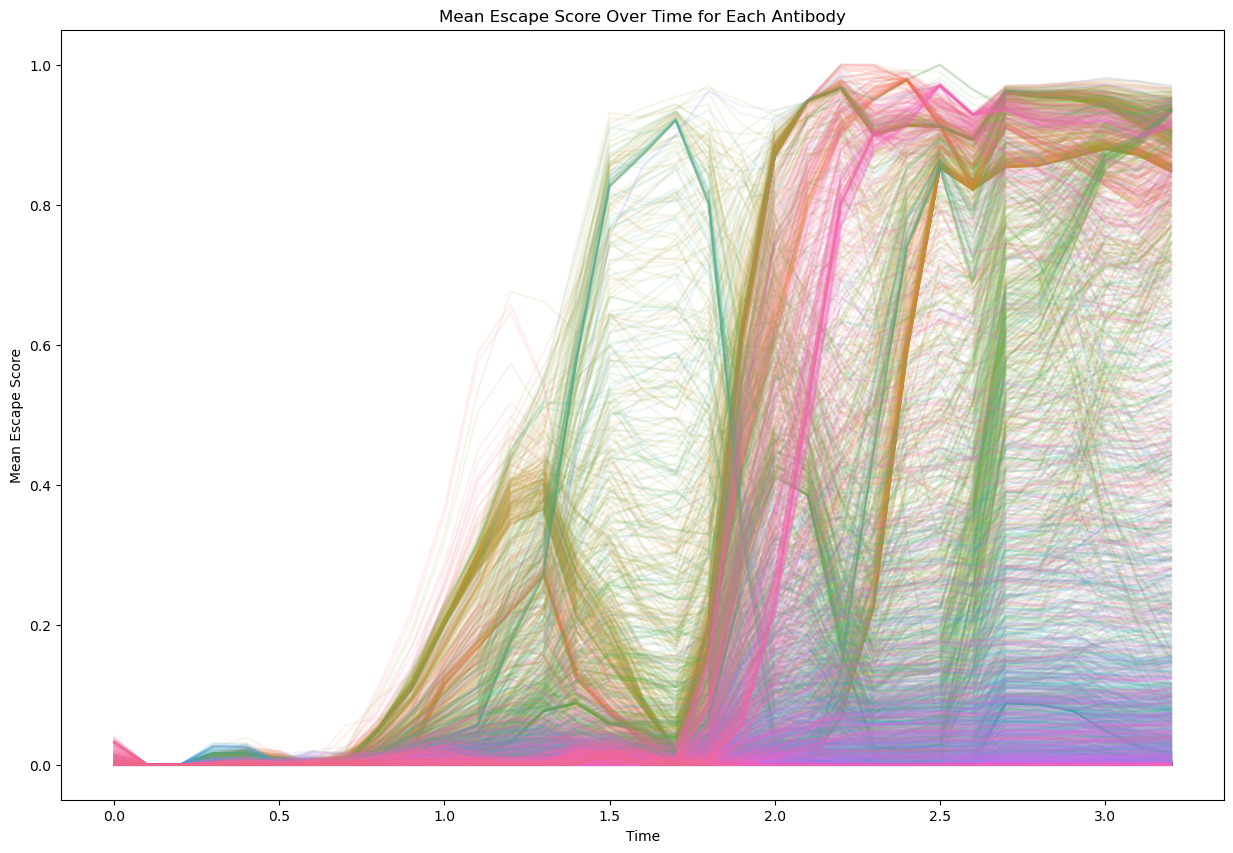

In [5]:
plt.figure(figsize=(15, 10))
sns.lineplot(data=ab_window_data, x='time', y='mean_escape', hue='antibody', legend=False, alpha=.1)

plt.title('Mean Escape Score Over Time for Each Antibody')
plt.xlabel('Time')
plt.ylabel('Mean Escape Score')
plt.show()

## K-Means Clustering on Antibody Escape Data Over Time

Now, we'll walk through the following steps:

1. **Data Pivoting**: Reshaping the dataset to set each antibody as a row and time points as columns.
2. **Optimal Cluster Determination**: Using the Elbow method to deduce the best cluster count for K-Means.
3. **K-Means Clustering**: Applying K-Means based on the optimal or pre-defined cluster count.
4. **Visualization**: Plotting the resulting clusters to observe antibody behavior over time.


Now import packages for the K Means Clustering from the Scikit Learn library

In [6]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import numpy as np

Next, pivot the dataframe to have one row per antibody and one column per time point

In [7]:
pivot_df = ab_window_data.pivot(index=['antibody', 'ab_group'], columns= 'time', values='mean_escape').fillna(0)
pivot_df.head()

time                    0.0  0.1  0.2       0.3       0.4       0.5       0.6  \
antibody ab_group                                                               
1-57     D1        0.000000  0.0  0.0  0.000199  0.000659  0.000466  0.000000   
2-15     C         0.000000  0.0  0.0  0.015625  0.015152  0.000000  0.000000   
7D6      C         0.000000  0.0  0.0  0.015625  0.015152  0.000000  0.000000   
ADG-2    F3        0.029848  0.0  0.0  0.002077  0.002014  0.000000  0.002413   
B38      A         0.000000  0.0  0.0  0.005264  0.024388  0.019283  0.000000   

time                    0.7       0.8       0.9  ...       2.3       2.4  \
antibody ab_group                                ...                       
1-57     D1        0.001060  0.002654  0.007889  ...  0.051163  0.048504   
2-15     C         0.000000  0.050000  0.111464  ...  0.905975  0.916940   
7D6      C         0.000000  0.050000  0.108108  ...  0.900000  0.913043   
ADG-2    F3        0.002368  0.008737  0.019526  ...  0.918549  0.885225   
B38      A         0.005145  0.044115  0.099816  ...  0.994930  0.982737   

time                    2.5       2.6       2.7       2.8       2.9       3.0  \
antibody ab_group                                                               
1-57     D1        0.056571  0.168434  0.225069  0.268755  0.385906  0.546923   
2-15     C         0.913522  0.894991  0.962195  0.959045  0.958695  0.951932   
7D6      C         0.911765  0.892857  0.959815  0.955176  0.952142  0.941461   
ADG-2    F3        0.884084  0.899603  0.856059  0.838483  0.814406  0.754451   
B38      A         0.947900  0.928571  0.965233  0.968423  0.970834  0.961822   

time                    3.1       3.2  
antibody ab_group                      
1-57     D1        0.635897  0.744227  
2-15     C         0.935824  0.920847  
7D6      C         0.918737  0.891953  
ADG-2    F3        0.744743  0.822356  
B38      A         0.953200  0.947968  

[5 rows x 33 columns]

### Determining the Optimal Number of Clusters
Here, we're employing the Elbow method. This visual technique helps find the number of clusters where the rate of reduction in distortion slows down, suggesting an optimal cluster count.


/home/oabdelaz/miniconda3/envs/ncov-ab-escape/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/home/oabdelaz/miniconda3/envs/ncov-ab-escape/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/home/oabdelaz/miniconda3/envs/ncov-ab-escape/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/home/oabdelaz/miniconda3/envs/ncov-ab-escape/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature nam

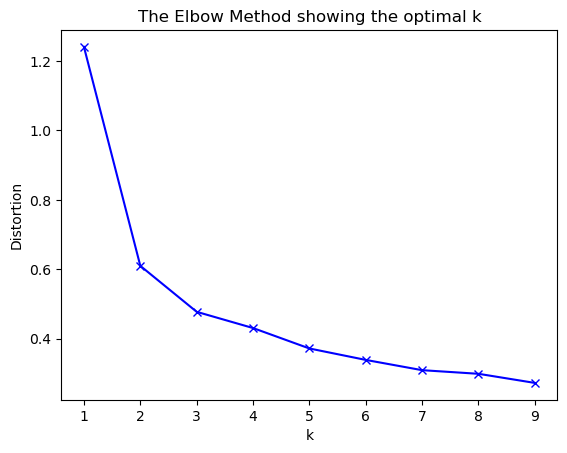

In [8]:
# Compute optimal number of clusters using Elbow method
distortions = []
K = range(1,10) # This range can be adjusted depending on use case
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0)
    kmeanModel.fit(pivot_df)
    distortions.append(sum(np.min(cdist(pivot_df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / pivot_df.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


### K-Means Clustering Application
After deducing or choosing the number of clusters, we proceed to segment the data using K-Means.


In [9]:
# Pick the optimal number of clusters by examining the elbow plot
n_clusters = 15 # change this based on your elbow plot result

#NOTE: we chose a large K value due to the large dataset we used

# Perform k-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(pivot_df)

# Add the cluster labels back into the pivot dataframe
pivot_df['cluster'] = kmeans.labels_


/home/oabdelaz/miniconda3/envs/ncov-ab-escape/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


### Visualizing Clustering Results
For each identified cluster, we visualize antibodies over time. This allows us to observe patterns and compare the behavior of different antibodies and antibody groups.


/tmp/ipykernel_20033/1987494355.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=cluster_df, x='time', y='value', ci=None, estimator=np.mean, color='r', ax=axs[2])


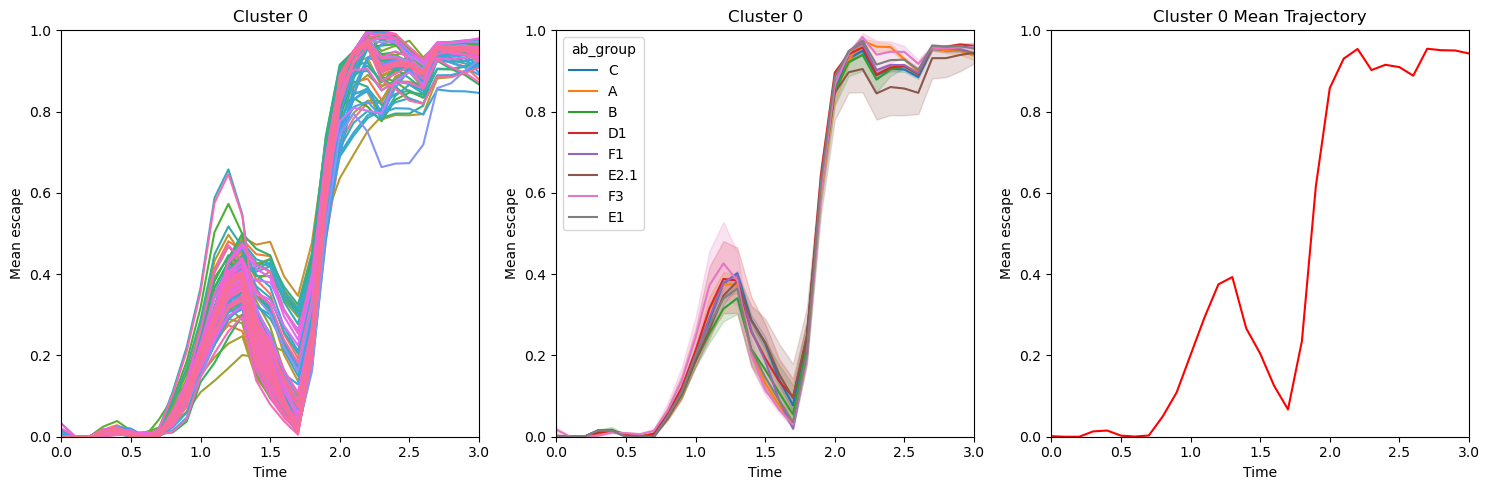

/tmp/ipykernel_20033/1987494355.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=cluster_df, x='time', y='value', ci=None, estimator=np.mean, color='r', ax=axs[2])


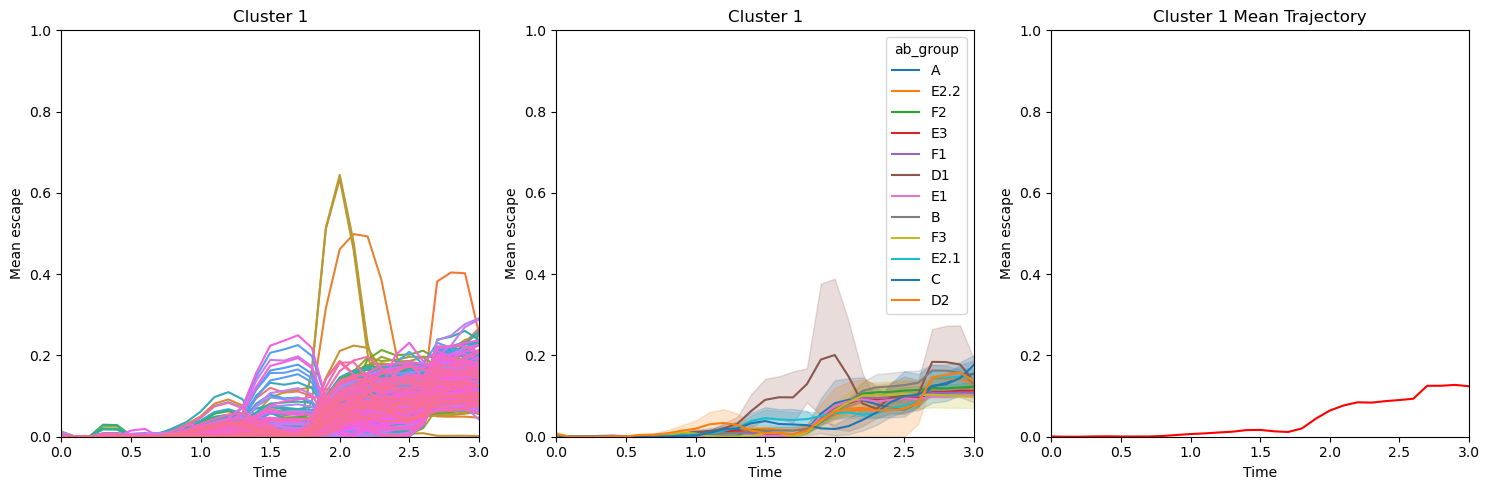

/tmp/ipykernel_20033/1987494355.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=cluster_df, x='time', y='value', ci=None, estimator=np.mean, color='r', ax=axs[2])


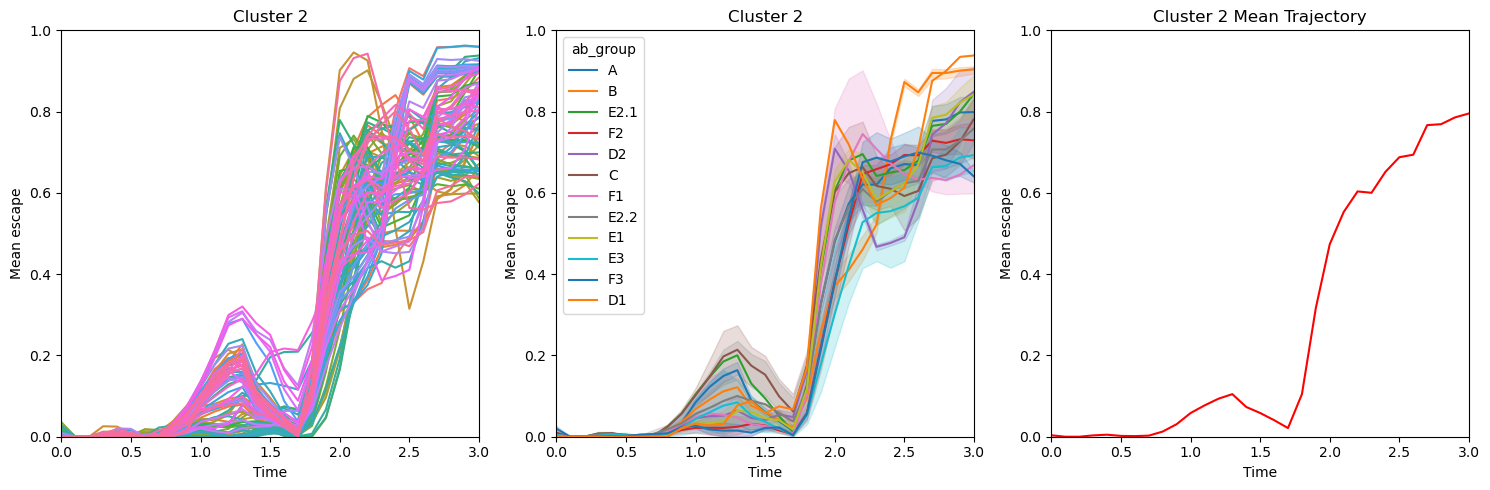

/tmp/ipykernel_20033/1987494355.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=cluster_df, x='time', y='value', ci=None, estimator=np.mean, color='r', ax=axs[2])


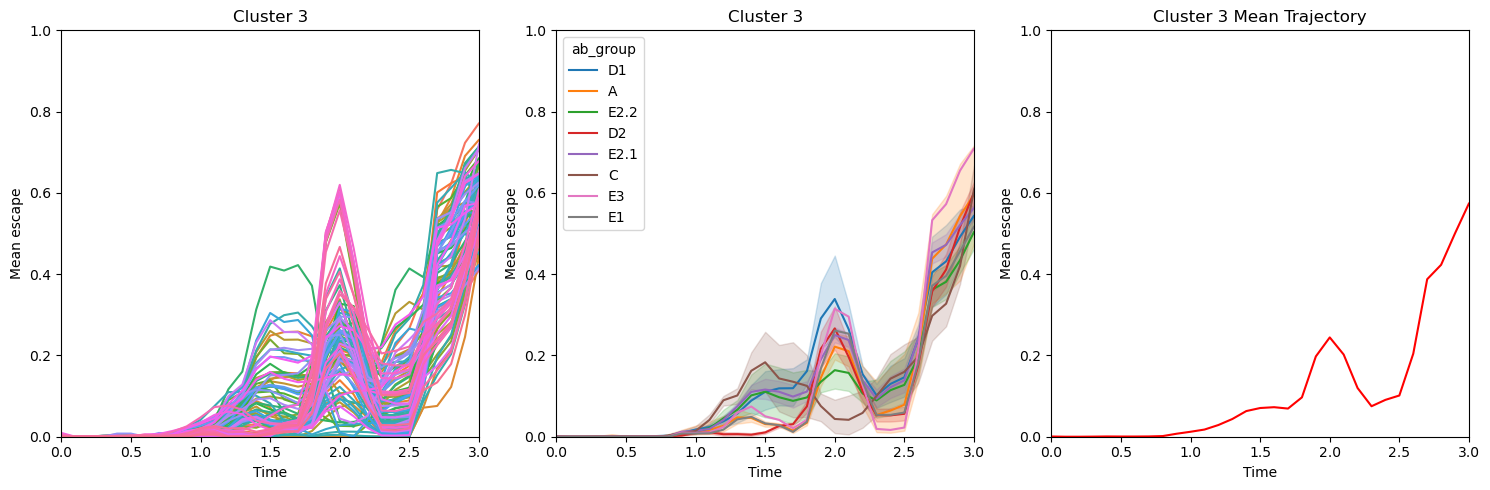

/tmp/ipykernel_20033/1987494355.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=cluster_df, x='time', y='value', ci=None, estimator=np.mean, color='r', ax=axs[2])


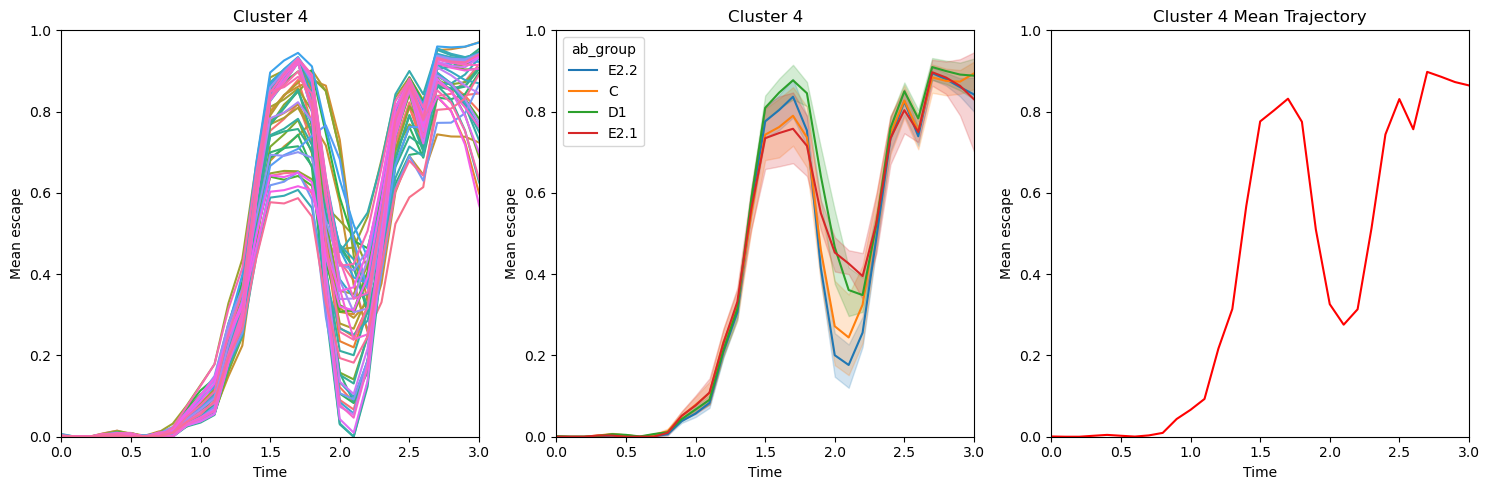

/tmp/ipykernel_20033/1987494355.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=cluster_df, x='time', y='value', ci=None, estimator=np.mean, color='r', ax=axs[2])


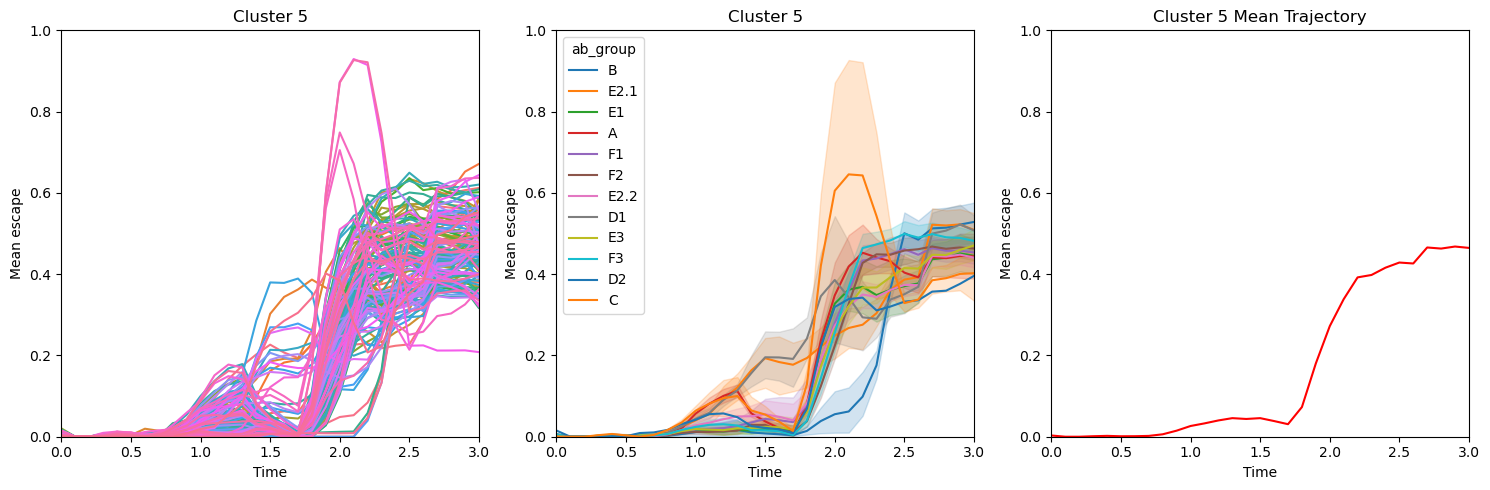

/tmp/ipykernel_20033/1987494355.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=cluster_df, x='time', y='value', ci=None, estimator=np.mean, color='r', ax=axs[2])


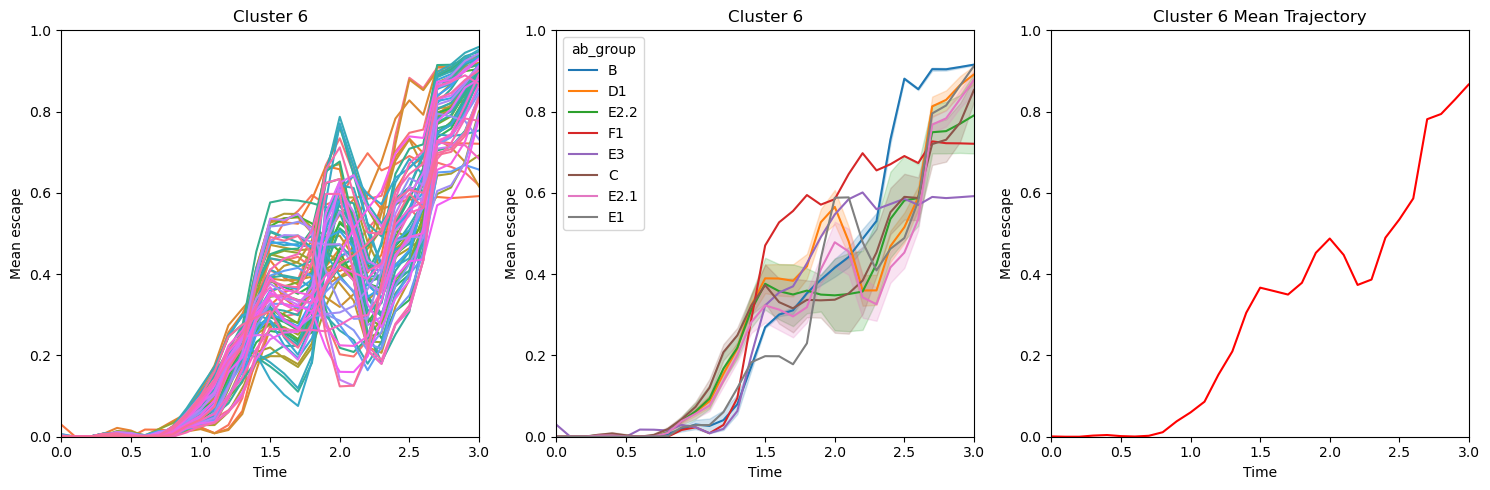

/tmp/ipykernel_20033/1987494355.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=cluster_df, x='time', y='value', ci=None, estimator=np.mean, color='r', ax=axs[2])


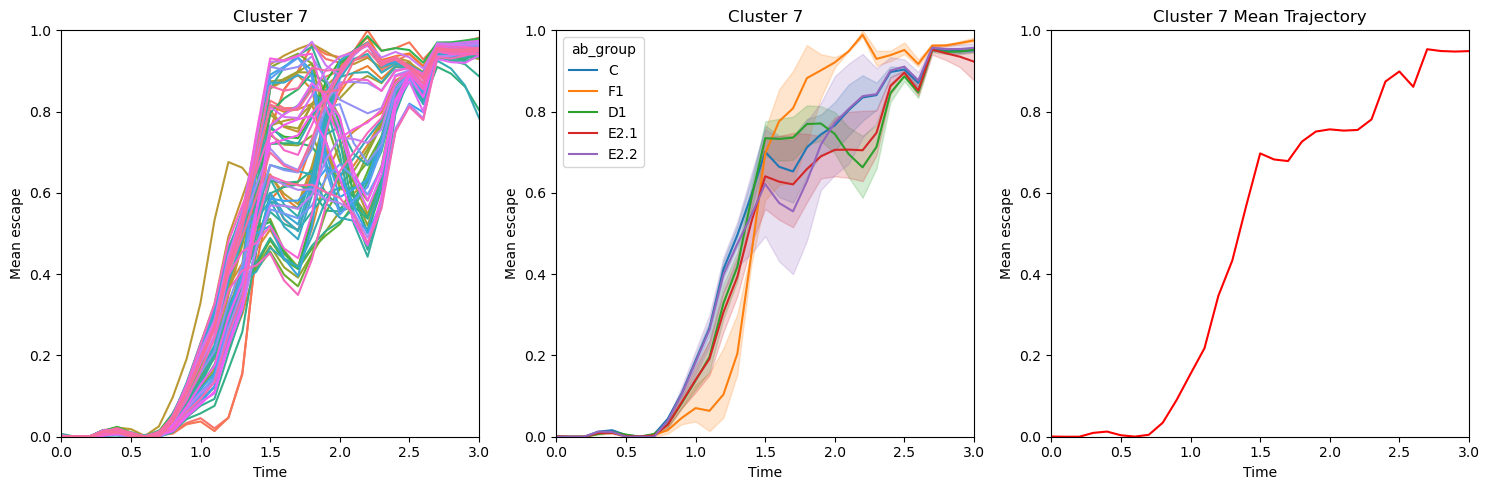

/tmp/ipykernel_20033/1987494355.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=cluster_df, x='time', y='value', ci=None, estimator=np.mean, color='r', ax=axs[2])


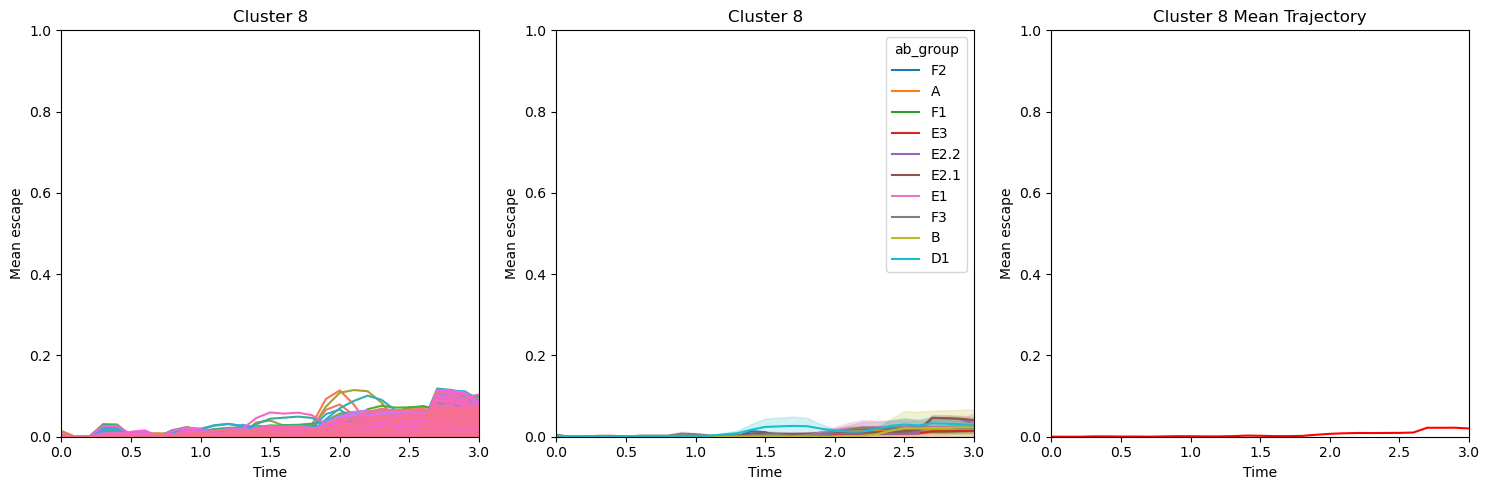

/tmp/ipykernel_20033/1987494355.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=cluster_df, x='time', y='value', ci=None, estimator=np.mean, color='r', ax=axs[2])


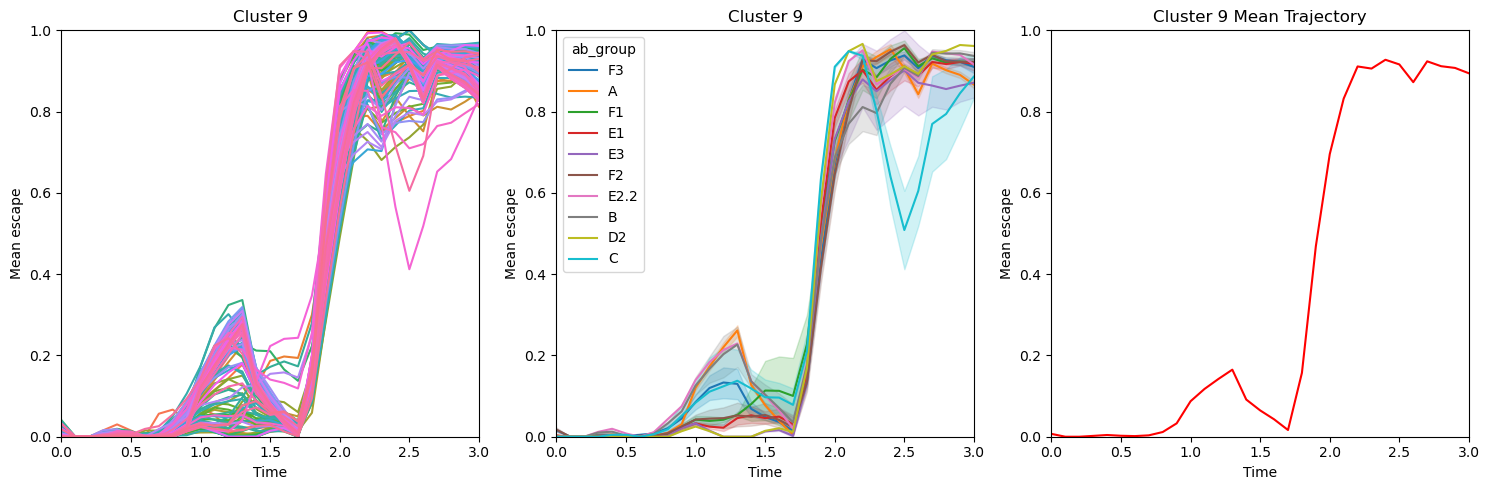

/tmp/ipykernel_20033/1987494355.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=cluster_df, x='time', y='value', ci=None, estimator=np.mean, color='r', ax=axs[2])


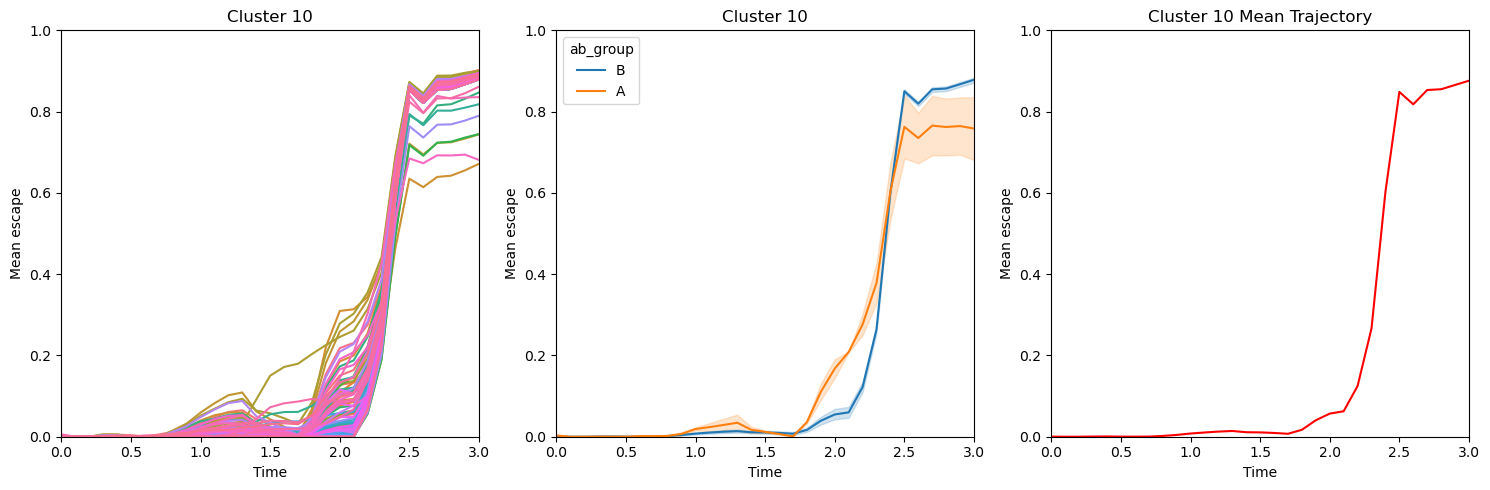

/tmp/ipykernel_20033/1987494355.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=cluster_df, x='time', y='value', ci=None, estimator=np.mean, color='r', ax=axs[2])


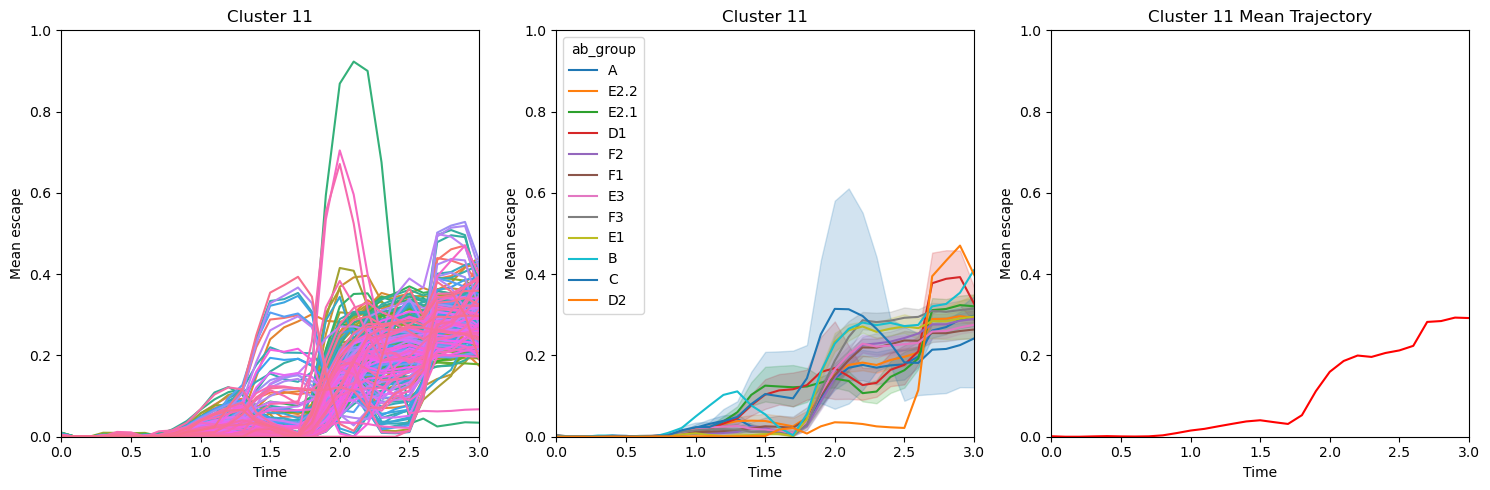

/tmp/ipykernel_20033/1987494355.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=cluster_df, x='time', y='value', ci=None, estimator=np.mean, color='r', ax=axs[2])


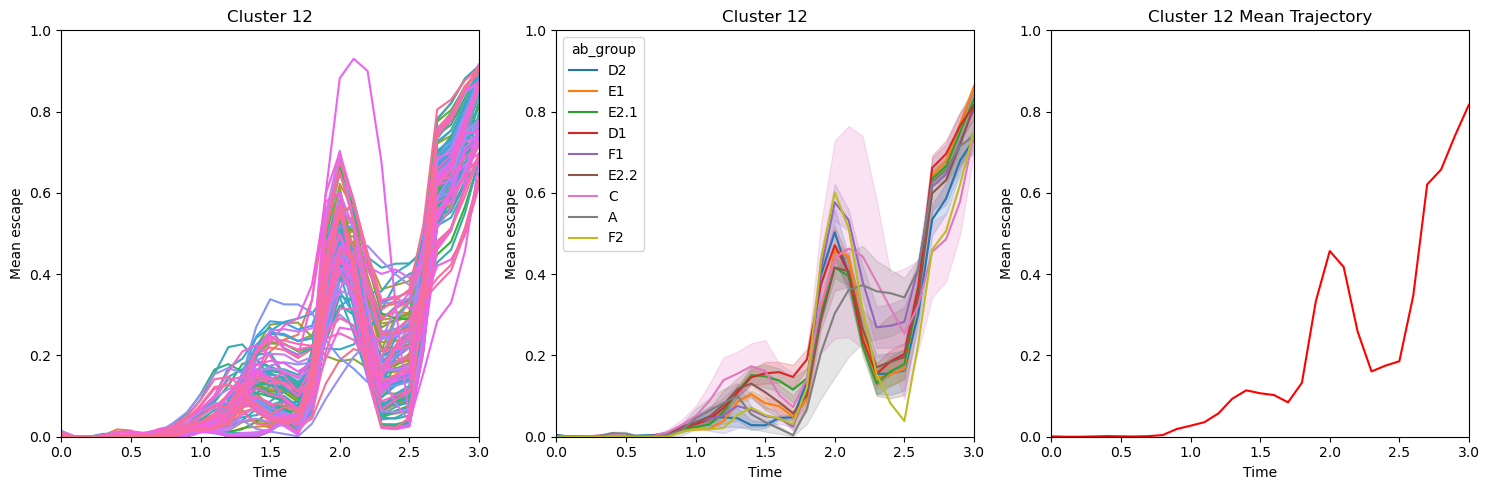

/tmp/ipykernel_20033/1987494355.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=cluster_df, x='time', y='value', ci=None, estimator=np.mean, color='r', ax=axs[2])


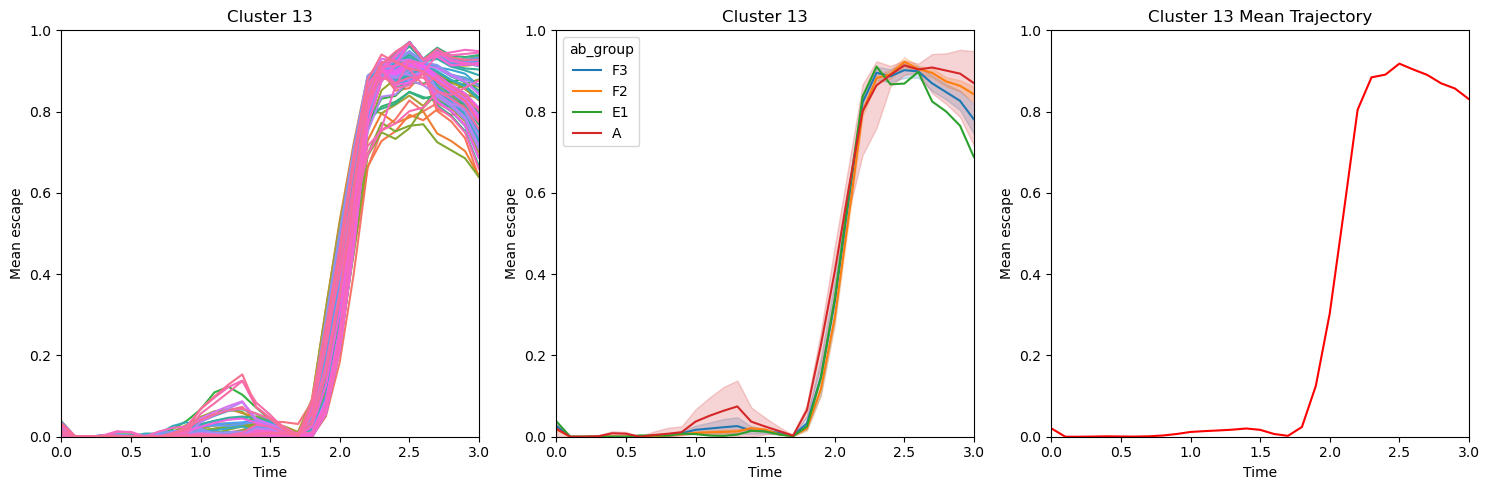

/tmp/ipykernel_20033/1987494355.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=cluster_df, x='time', y='value', ci=None, estimator=np.mean, color='r', ax=axs[2])


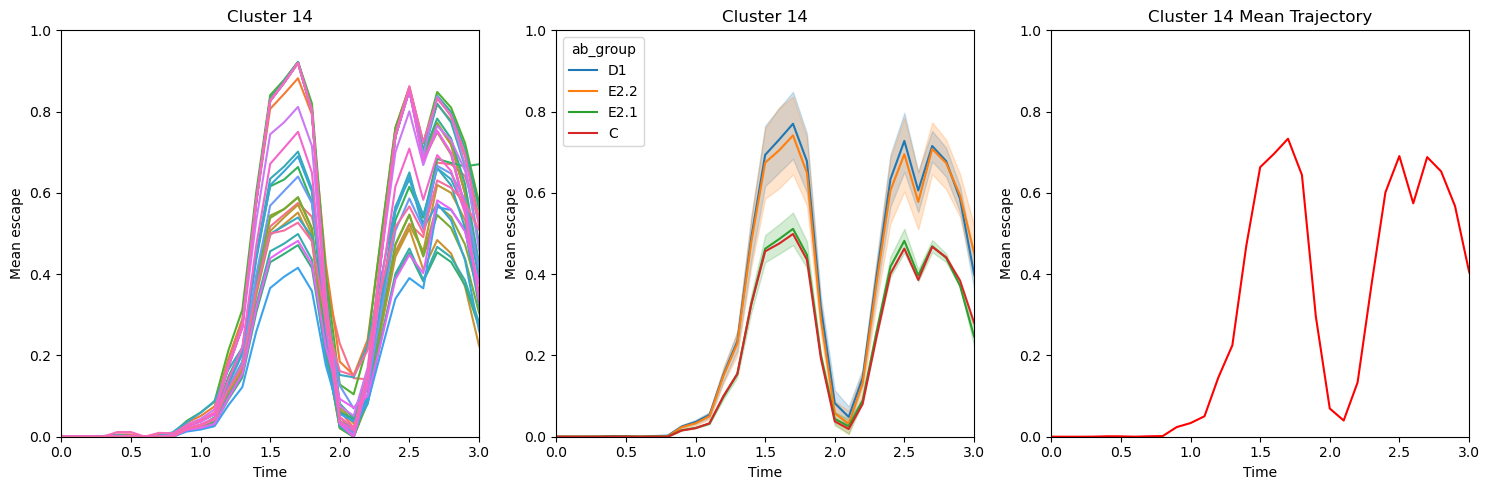

In [10]:
# For each cluster, plot all the antibodies in the cluster
# For each cluster, plot all the antibodies in the cluster
for cluster in range(n_clusters):
    cluster_df = pivot_df[pivot_df['cluster'] == cluster].drop(columns='cluster').reset_index()
    cluster_df = cluster_df.melt(id_vars=['ab_group', 'antibody'])
    cluster_df.time = cluster_df.time.astype(float)
    
    # Start subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5)) 
    
    #Normal plot with all antibodies in the cluster
    sns.lineplot(data=cluster_df, x='time', y='value', hue='antibody', ax=axs[0],legend=False)
    axs[0].set_title(f'Cluster {cluster}')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Mean escape')
    
    #Plot classified by antibody group
    sns.lineplot(data=cluster_df, x='time', y='value', hue='ab_group', palette='tab10', ax=axs[1])
    axs[1].set_title(f'Cluster {cluster}')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Mean escape')

    #Plot displaying mean trajectory
    sns.lineplot(data=cluster_df, x='time', y='value', ci=None, estimator=np.mean, color='r', ax=axs[2])
    axs[2].set_title(f'Cluster {cluster} Mean Trajectory')
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('Mean escape')

    # set x and y axis limits
    axs[0].set_xlim([0, 3]) 
    axs[0].set_ylim([0, 1])
    axs[1].set_xlim([0, 3]) 
    axs[1].set_ylim([0, 1])
    axs[2].set_xlim([0, 3]) 
    axs[2].set_ylim([0, 1])
    
    #Show the plot
    plt.tight_layout()
    plt.show()

## Visualizing Antibody Group Density Across Clusters

In this section, we aim to visualize the distribution and density of different antibody groups across the clusters identified previously.

The steps are as follows:

1. **Data organization**: Group the pivoted data based on the cluster and antibody group.
2. **Normalization**: Normalize the grouped data to get the fraction of each antibody group in every cluster.
3. **Heatmap Generation**: Create a cluster map (a type of heatmap) to visually represent the density of each antibody group across clusters.


### Data organization 
First, let's organize the data to get a count of each antibody group in every cluster. The count is then converted to percentages for easier interpretation.

In [11]:
# Create a new dataframe to hold cluster vs ab_group counts
cluster_ab_group_df = pivot_df.groupby(['cluster', 'ab_group']).size().unstack(fill_value=0)

# Normalize the counts to represent fractions within each cluster
cluster_ab_group_df = cluster_ab_group_df.div(cluster_ab_group_df.sum(axis=1), axis=0)

# Convert fractions to percentages
cluster_ab_group_df = cluster_ab_group_df * 100

### Generating the Cluster Map
Using Seaborn's `clustermap` function, we'll visualize the density of each antibody group across different clusters. The color gradient (from white to black) indicates the density percentage.


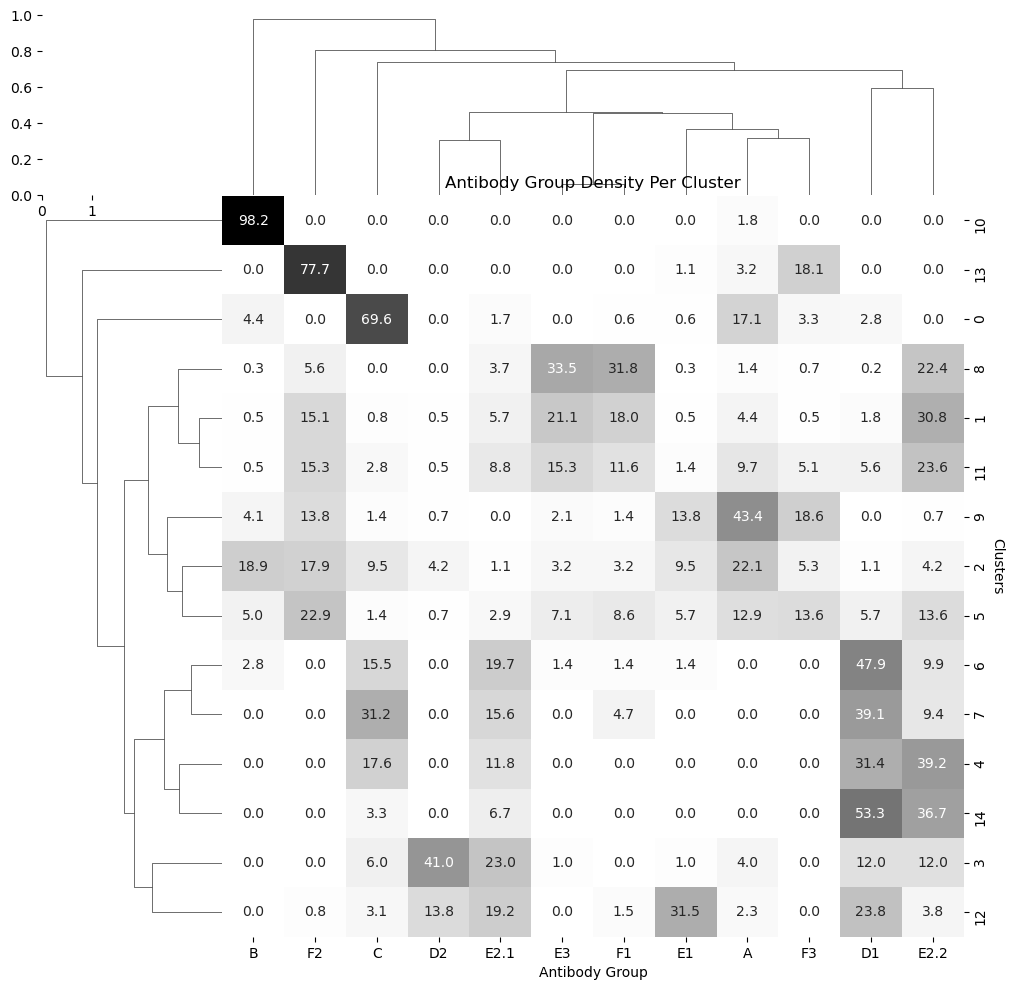

In [14]:
# Making a color gradient
cmap = colors.LinearSegmentedColormap.from_list("mycmap", ["white", "black"])

# Initializing the ClusterMap
g = sns.clustermap(cluster_ab_group_df, annot=True, fmt=".1f", row_cluster=True, col_cluster=True, cmap=cmap, cbar=False)

# Making x-axis label on bottom
g.ax_heatmap.set_xlabel('Antibody Group') 

# Making y-axis label on the right
g.ax_heatmap.set_ylabel('Clusters', rotation=-90, va="baseline")

# Setting the title for the clustermap
g.ax_heatmap.set_title('Antibody Group Density Per Cluster')

plt.show()


## Success! 
Now are data is clustered based on similar patterns and we can vizualize our data using clusters and the cluster map!